In [1]:
import os
import random
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [2]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

# Train And Test

In [3]:
dataset=datasets.ImageFolder(root=("/kaggle/input/indian-food-images-dataset/Indian Food Images/Indian Food Images"),transform=transform)

In [4]:
class_names=dataset.classes
print(class_names)
print(len(class_names))

['adhirasam', 'aloo_gobi', 'aloo_matar', 'aloo_methi', 'aloo_shimla_mirch', 'aloo_tikki', 'anarsa', 'ariselu', 'bandar_laddu', 'basundi', 'bhatura', 'bhindi_masala', 'biryani', 'boondi', 'butter_chicken', 'chak_hao_kheer', 'cham_cham', 'chana_masala', 'chapati', 'chhena_kheeri', 'chicken_razala', 'chicken_tikka', 'chicken_tikka_masala', 'chikki', 'daal_baati_churma', 'daal_puri', 'dal_makhani', 'dal_tadka', 'dharwad_pedha', 'doodhpak', 'double_ka_meetha', 'dum_aloo', 'gajar_ka_halwa', 'gavvalu', 'ghevar', 'gulab_jamun', 'imarti', 'jalebi', 'kachori', 'kadai_paneer', 'kadhi_pakoda', 'kajjikaya', 'kakinada_khaja', 'kalakand', 'karela_bharta', 'kofta', 'kuzhi_paniyaram', 'lassi', 'ledikeni', 'litti_chokha', 'lyangcha', 'maach_jhol', 'makki_di_roti_sarson_da_saag', 'malapua', 'misi_roti', 'misti_doi', 'modak', 'mysore_pak', 'naan', 'navrattan_korma', 'palak_paneer', 'paneer_butter_masala', 'phirni', 'pithe', 'poha', 'poornalu', 'pootharekulu', 'qubani_ka_meetha', 'rabri', 'ras_malai', 'ras

In [5]:
torch.manual_seed(10)
test_size = len(dataset)//5
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)   

(3200, 800)

In [6]:
train_loader=DataLoader(train_ds,batch_size=10,shuffle=True)
test_loader=DataLoader(test_ds,batch_size=10)

# Checking Images And Labels

In [7]:
for images, labels in train_loader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im=make_grid(images,nrow=5)

Label: [63  0 37 17 68  3 19 13 73 12]
Class: pithe adhirasam jalebi chana_masala rabri aloo_methi chhena_kheeri boondi sheer_korma biryani


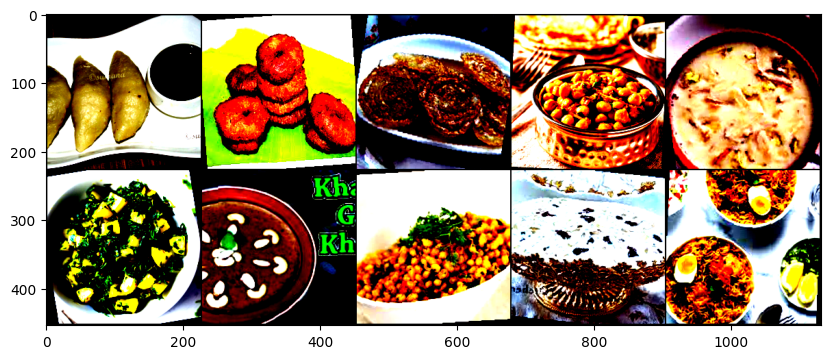

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [9]:
inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                    std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

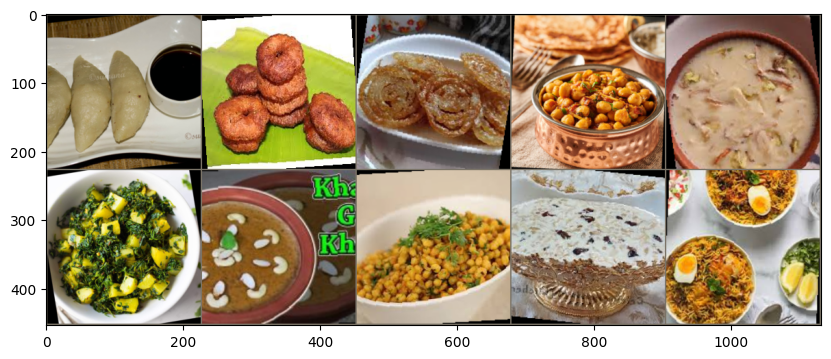

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

# Model Training

In [11]:
# Code for CNN-ResNet model and training
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [12]:
# Set random seed for reproducibility
torch.manual_seed(10)

# Number of classes in your dataset
num_classes = len(class_names)

# Create the model
model = FineTunedResNet(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop
num_epochs = 10  


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.5MB/s]


In [13]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_samples

    scheduler.step()

    # Print average loss and accuracy per epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Accuracy: {accuracy * 100:.2f}%")


Epoch 1/10, Loss: 3.5726512502878904, Accuracy: 16.28%
Epoch 2/10, Loss: 2.0994640812277794, Accuracy: 46.62%
Epoch 3/10, Loss: 1.5232041927054525, Accuracy: 60.66%
Epoch 4/10, Loss: 1.204502679221332, Accuracy: 67.56%
Epoch 5/10, Loss: 0.923341677710414, Accuracy: 76.66%
Epoch 6/10, Loss: 0.7259360027033835, Accuracy: 82.06%
Epoch 7/10, Loss: 0.5870664684101939, Accuracy: 86.03%
Epoch 8/10, Loss: 0.4191608934663236, Accuracy: 92.03%
Epoch 9/10, Loss: 0.3759646042832173, Accuracy: 92.41%
Epoch 10/10, Loss: 0.351756747905165, Accuracy: 93.88%


In [14]:
# Validation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on the test set: {100 * correct / total}%")

Accuracy on the test set: 69.875%


# Model Evaluation

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Evaluate on the test set
true_labels, predicted_labels = evaluate_model(model, test_loader)


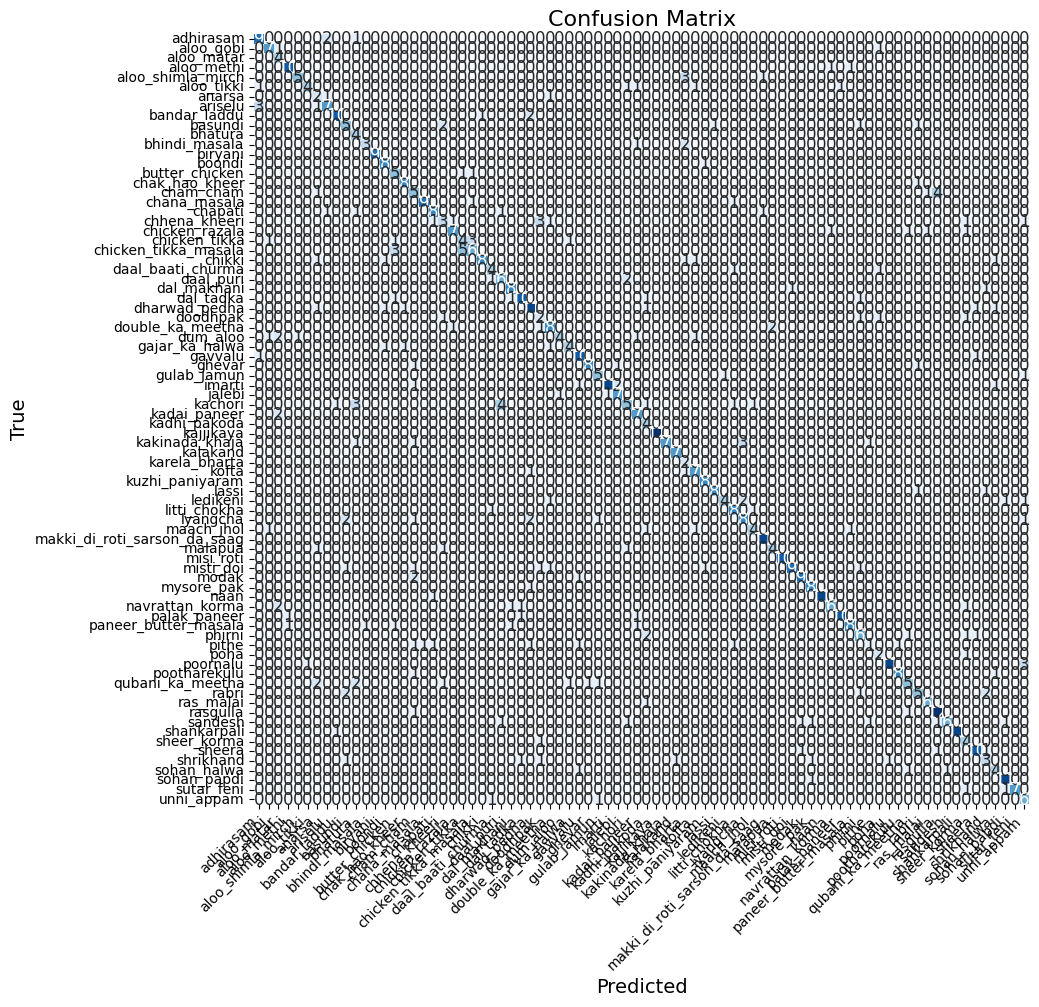

In [16]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# Evaluate on the test set
true_labels, predicted_labels = evaluate_model(model, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Increase the size of the confusion matrix
plt.figure(figsize=(10, 10))

# Customize the heatmap
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={'size': 12}  # Adjust font size for annotations
)

# Rotate tick labels for better alignment
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Add labels and title
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Show the plot
plt.show()


In [17]:
# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


Classification Report:
                              precision    recall  f1-score   support

                   adhirasam       0.64      0.75      0.69        12
                   aloo_gobi       0.70      0.78      0.74         9
                  aloo_matar       0.36      1.00      0.53         4
                  aloo_methi       0.83      0.83      0.83        12
           aloo_shimla_mirch       0.83      0.56      0.67         9
                  aloo_tikki       0.80      0.44      0.57         9
                      anarsa       0.22      0.50      0.31         4
                     ariselu       0.64      0.64      0.64        11
                bandar_laddu       0.83      0.77      0.80        13
                     basundi       0.45      0.50      0.48        10
                     bhatura       0.33      1.00      0.50         4
               bhindi_masala       0.75      0.50      0.60         6
                     biryani       1.00      1.00      1.00       

In [18]:
# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 67.88%


In [19]:
# Precision, Recall, and F1 Score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

Precision: 71.33%
Recall: 67.88%
F1 Score: 68.11%


# Visualizing Model Predictions

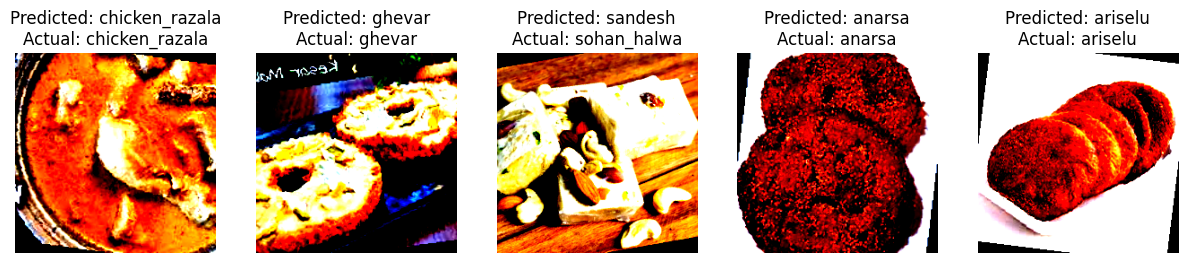

In [20]:
def visualize_predictions(model, dataloader, num_images=5):
    model.eval()
    images_so_far = 0
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(min(inputs.size()[0], num_images - images_so_far)):
                ax[images_so_far].imshow(np.transpose(inputs[j].cpu().numpy(), (1, 2, 0)))
                ax[images_so_far].axis('off')
                ax[images_so_far].set_title(f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')
                images_so_far += 1

                if images_so_far == num_images:
                    plt.show()
                    return

# Visualize predictions on the test set
visualize_predictions(model, test_loader, num_images=5)


# Exploring Misclassified Images

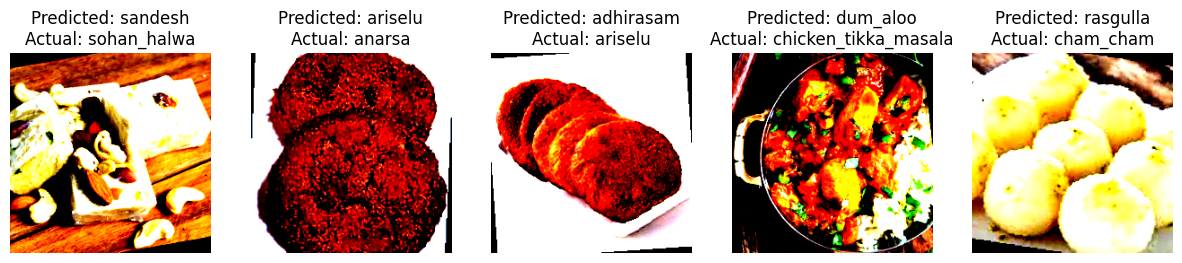

In [21]:
def visualize_misclassifications(model, dataloader, num_images=5):
    model.eval()
    misclassified_images = 0
    fig, ax = plt.subplots(1, num_images, figsize=(15, 5))

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(min(inputs.size()[0], num_images - misclassified_images)):
                if preds[j] != labels[j]:
                    ax[misclassified_images].imshow(np.transpose(inputs[j].cpu().numpy(), (1, 2, 0)))
                    ax[misclassified_images].axis('off')
                    ax[misclassified_images].set_title(f'Predicted: {class_names[preds[j]]}\nActual: {class_names[labels[j]]}')
                    misclassified_images += 1

                    if misclassified_images == num_images:
                        plt.show()
                        return

# Visualize misclassified images on the test set
visualize_misclassifications(model, test_loader, num_images=5)

